# Starbucks Promotion Optimization Strategy

<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
## Background Information

The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

Our task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, our goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

## First look

In [1]:
import warnings
warnings.filterwarnings("ignore")

from itertools import combinations
from collections import Counter

import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import xgboost as xgb

from scipy.stats import ks_2samp
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

train_data = pd.read_csv('data/training.csv')
test_data = pd.read_csv('data/test.csv')

Using TensorFlow backend.


The numbers of customers in control and treatment groups are roughly similar. However, the data is highly imbalanced in terms of number of purchasers. 

In [2]:
print('purchase: ', Counter(train_data['purchase']))
print('promotion: ', Counter(train_data['Promotion']))

purchase:  Counter({0: 83494, 1: 1040})
promotion:  Counter({'Yes': 42364, 'No': 42170})


Except for `V2` and `V3` which are continuous, the remaining variables are discrete. Since we don't have much information about these discrete predictors, we don't know whether their numerical values actually carry order of magnitude information or there are some underlying categories and they should be treated as catergorical variables. Due to the lack of context, we will just treat them as they are, i.e. numerical discrete variables. 

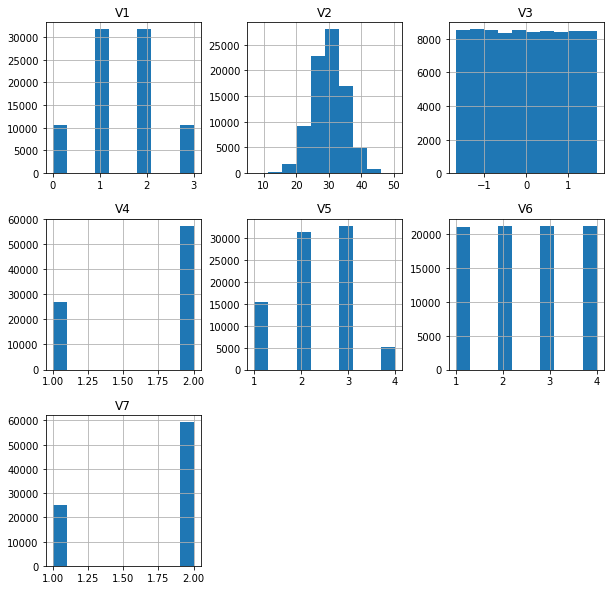

In [3]:
all_predictors = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']
train_data[all_predictors].hist(figsize=(10, 10));

The Kolmogorov–Smirnov test is a non-parametric test that helps us quantify a distance between the empirical distribution functions of two samples. Based on this test and the class label information, we can see how well each predictor helps seperate the two classes of our binary target variable. 

In [4]:
ks_stats, p_vals = [], []
for col in all_predictors:
    stat, pval = ks_2samp(train_data.loc[train_data['purchase'] == 0, col], 
                          train_data.loc[train_data['purchase'] == 1, col])
    ks_stats.append(stat)
    p_vals.append(round(pval, 4))
ks_res = (
    pd.DataFrame({'column': all_predictors, 'ks_statistic': ks_stats, 'p_value': p_vals})
    .sort_values(by=['ks_statistic'], ascending=False)
)
ks_res

,column,ks_statistic,p_value
3,V4,0.136494,0.0000
4,V5,0.079250,0.0000
2,V3,0.037236,0.1133
0,V1,0.023627,0.6101
1,V2,0.017718,0.9013
5,V6,0.010244,0.9999
6,V7,0.004636,1.0000


Apparently, only the K-S statistics of `V4` and `V5` are statistically signficant, which suggests that only these 2 variables might be predictive of predicting whether a customer purchases or not. Therefore, moving forward, we will only use these 2 predictors for modeling.

In [5]:
predictors = ['V4', 'V5']

## Utility functions

In [6]:
def calculate_num_ctrl_treat(data, treat_col='Promotion'):
    """
    Calculate number of purchasers as well as total number of customers in both promotion and
    non-promotion groups
    :param data: data frame that includes customer information (buy-or-not, promoted-to-or-not)
    :param treat_col: name of column that indicates whether a customer receives promotion
    :return: #purchasers in treatment group, #customers in treatement group, 
             #purchasers in control group, #customers in control group
    """
    purch_treat = len(data[(data[treat_col] == 'Yes') & (data['purchase'] == 1)])
    cust_treat = len(data[(data[treat_col] == 'Yes')])

    purch_ctrl = len(data[(data[treat_col] == 'No') & (data['purchase'] == 1)])
    cust_ctrl = len(data[(data[treat_col] == 'No')])
    
    return purch_treat, cust_treat, purch_ctrl, cust_ctrl

def calculate_irr(data, treat_col='Promotion'):
    """
    Calculate incremental response rate (see formula above)
    :param data: data frame that includes customer information (buy-or-not, promoted-to-or-not)
    :param treat_col: name of column that indicates whether a customer receives promotion
    :return: incremental response rate
    """
    purch_treat, cust_treat, purch_ctrl, cust_ctrl = calculate_num_ctrl_treat(data, treat_col)
    irr = (purch_treat/cust_treat) - (purch_ctrl/cust_ctrl) 
    return irr

def calculate_nir(data, treat_col='Promotion'):
    """
    Calculate net incremental revenue (see formula above)
    :param data: data frame that includes customer information (buy-or-not, promoted-to-or-not)
    :param treat_col: name of column that indicates whether a customer receives promotion
    :return: net incremental revenue
    """
    purch_treat, cust_treat, purch_ctrl, _ = calculate_num_ctrl_treat(data, treat_col)
    nir = (10*purch_treat - 0.15*cust_treat) - 10*purch_ctrl
    return nir

def display_biz_metrics(data, treat_col='Promotion'):
    """
    Display calculated IRR and NIR
    :param data: data frame that includes customer information (buy-or-not, promoted-to-or-not)
    :param treat_col: name of column that indicates whether a customer receives promotion
    :return: None
    """
    try:
        print('Incremental Response Rate: ', calculate_irr(data, treat_col))
        print('Net Incremental Revenue: ', calculate_nir(data, treat_col))
    except ZeroDivisionError:
        print('ZeroDivisionError')

def jitter(a_series, noise_reduction=1000000):
    """
    Add subtle and random noise to a numerical value to avoid the problem of duplicate bin edges 
    when performing quantile-based discretization
    :param a_series: series of numerical values
    :noise_reduction: magnitude of noise reduction
    :return: series of values that have been jittered
    """
    return (np.random.random(len(a_series)) * a_series.std()/noise_reduction) - (a_series.std() / (2*noise_reduction))

def create_lift_df(data, treat_prob, ctrl_prob):
    """
    Add lift value and its corresponding decile to the original dataframe provided
    :param data: data frame that includes customer information (buy-or-not, promoted-to-or-not)
    :param treat_prob: predicted probability of buying when customer is in treatment group
    :param ctrl_prob: predicted probability of buying when customer is control group
    :return: original dataframe with added columns
    """
    lift_df = (
        data
        .assign(lift = treat_prob - ctrl_prob,
                # smaller decile, higher lift
                lift_decile = lambda x: pd.qcut(x['lift'] + jitter(x['lift']), 10, labels=[i for i in range(10, 0, -1)])) 
        .sort_values(by='lift_decile', ascending=False)
        .reset_index(drop=True)
    )
    return lift_df

## Baseline model (assignment in current dataset - `Promotions` column)

In [7]:
print('Train data:')
display_biz_metrics(train_data)

Train data:
Incremental Response Rate:  0.009454547819772702
Net Incremental Revenue:  -2334.5999999999995


In [8]:
print('Test data:')
display_biz_metrics(test_data)

Test data:
Incremental Response Rate:  0.009593158278250108
Net Incremental Revenue:  -1132.1999999999998


In addition to these results, Starbucks states in their document that they were able to come up with a model with an IRR of 0.0188 and an NIR of 189.45 on the test set. We can also use these numbers as a benchmark. 

## The two-model approach

This approach consists building two seperate models for treatment and control groups. These models tell us the likehood of a customer to purchase when they receive the promotion offers and when they don't, respectively. After these two classifiers are constructed, we score all customers using both models. Thus, each customer now has two probabilities and the difference between these two is the uplift score.   

In [9]:
train, valid = train_test_split(train_data, test_size=0.2, random_state=42)

train_treat_grp = train[train['Promotion'] == 'Yes']
train_ctrl_grp = train[train['Promotion'] == 'No']
    
X_train_treat = train_treat_grp[predictors]
y_train_treat = train_treat_grp['purchase']
    
X_train_ctrl = train_ctrl_grp[predictors]
y_train_ctrl = train_ctrl_grp['purchase']

X_test = test_data[predictors]
y_test = test_data['purchase']

X_valid = valid[predictors]
y_valid = valid['purchase']

To deal with the imbalance classification problem, we employ SMOTE to oversample our minority class. Please note that `sampling_strategy` is a parameter that can be tuned as well.

In [10]:
sm_treat = SMOTE(random_state=42, sampling_strategy=1)
sm_ctrl = SMOTE(random_state=42, sampling_strategy=1)

In [11]:
X_train_treat_sm, y_train_treat_sm = sm_treat.fit_sample(X_train_treat, y_train_treat)
X_train_ctrl_sm, y_train_ctrl_sm = sm_ctrl.fit_sample(X_train_ctrl, y_train_ctrl)

print('Distribution of target variable after SMOTE')
print('Train treatment group:', Counter(y_train_treat_sm))
print('Train control group:', Counter(y_train_ctrl_sm))

Distribution of target variable after SMOTE
Train treatment group: Counter({0: 33351, 1: 33351})
Train control group: Counter({0: 33444, 1: 33444})


Hyperparameter tuning is strongly recommended when model performance is of high priority. One thing to note here is that as you perform the cross-validation process, you need to make sure not to oversample the validation set. Thankfully, the `imblearn` package has its own `Pipeline` to handle the samplers correctly. The code for the modeling sequence would look something like this:

```
model_ct = Pipeline([
        ('os', SMOTE(random_state=42, sampling_strategy=1)),
        ('rf', RandomForestClassifier(random_state=42))
    ])
parameters = {
    'rf__n_estimators': (100, 500),
    'rf__min_samples_split': (2, 4)
}
cv = GridSearchCV(model_ct, param_grid=parameters)
cv.fit(X_train, y_train)
```

Due to time limitation and our focus on uplift models in this exercise, we didn't go through the hyperparameter tuning process. Instead, we just fit a random forest model using the default sklearn configurations and 500 trees. 

In [12]:
rf_treat = RandomForestClassifier(random_state=42, n_estimators=500).fit(X_train_treat_sm, y_train_treat_sm)
rf_ctrl = RandomForestClassifier(random_state=42, n_estimators=500).fit(X_train_ctrl_sm, y_train_ctrl_sm)

We then used to the trained models to predict the probabilities of purchasing on the validation set, given they are in the control or treatment group. As mentioned, the difference between the two scores is the lift value.  

In [13]:
valid_treat_prob = rf_treat.predict_proba(X_valid)[:, 1]
valid_ctrl_prob = rf_ctrl.predict_proba(X_valid)[:, 1]

valid_2m = create_lift_df(valid, valid_treat_prob, valid_ctrl_prob)
actual_lift = valid_2m.groupby(['lift_decile']).apply(lambda x: calculate_irr(x, 'Promotion'))
print('Mean of actual lift in validation set: {}%'.format(round((actual_lift * 100).mean(), 3)))

Mean of actual lift in validation set: 0.861%


To decide on which customers to target, we first split all our customers into 10 bins based on their lift values. Bin 1 is the bin with highest lift, and bin 10 with lowest lift. These bins will contain some customers who were in treatment and some in control group. The difference between treatment response rate and control response rate is the actual lift in that bin (while the orginal lift value used to split customers into bins is the predicted lift). 

In [14]:
actual_lift_df = (
    pd.DataFrame(actual_lift * 100)
    .reset_index()
    .rename(columns={'lift_decile': 'predicted_lift_decile', 0: 'actual_lift_perc'})
    .sort_values(by='predicted_lift_decile', ascending=False)
)
print('The average percentage of actual lift for each predicted lift decile: \n')
print(actual_lift_df)

The average percentage of actual lift for each predicted lift decile: 

  predicted_lift_decile  actual_lift_perc
9                     1          1.491176
8                     2          2.511176
7                     3          2.205414
6                     4          1.417740
5                     5          0.329335
4                     6          0.609249
3                     7          0.275306
2                     8         -0.261978
1                     9         -0.136122
0                    10          0.164795


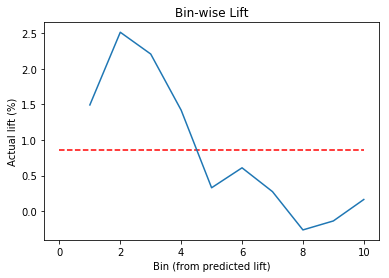

In [15]:
plt.plot([i for i in range(1, 11)], actual_lift_df['actual_lift_perc'])
plt.hlines(actual_lift_df['actual_lift_perc'].mean(), xmin=0, xmax=10, label='mean', color='r', linestyle='--')
plt.xlabel('Bin (from predicted lift)')
plt.ylabel('Actual lift (%)')
plt.title('Bin-wise Lift')
plt.show()

There are  are primarily four types of customers we deal with when planning a marketing campaign:  

1) Lost Causes: **don't** buy no matter receiving promotions or not  
2) Sure Things: **do** buy no matter receiving promotions or not  
3) Do-Not-Disturbs: buy if **don't** receive promotions  
4) Persuadables: buy if **do** receive promotions  

We want to pay attention to the “Persuadables”, those consumers who will only buy if they receive a promotion. We don't want to spend marketing dollars on those who are going buy anyway, those who do not want to receive our offers, or those who will not ever consider our offer. 

Based on the bin-wise lift figure above, it seems like customers in bin 1, 2, 3 and 4 with actual lift above average belong to the Persuadables group; customers in bin 5, 6, 7, 8 are in the Sure Things/Lost Causes groups and those in bin 8 and 10 with negative lift prefer to not be disturbed. According to these results from the validation set, we decide to send promotions to customers who are in the first four bins.  

In [16]:
test_treat_prob = rf_treat.predict_proba(X_test.values)[:, 1]
test_ctrl_prob = rf_ctrl.predict_proba(X_test.values)[:, 1]
test_2m = create_lift_df(X_test, test_treat_prob, test_ctrl_prob)

In [17]:
promos_2m = np.where(test_2m['lift_decile'].isin([1, 2, 3, 4]), 'Yes', 'No')
score_2m = test_data.iloc[promos_2m == 'Yes']
display_biz_metrics(score_2m)

Incremental Response Rate:  0.009133425459447612
Net Incremental Revenue:  -496.14999999999986


This is an improvement over the current assignment on the test data (`Promotions` column), especially in terms of NIR. Nevertheless, the performance of this model is still far behind that of the benchmark model by Starbucks. 

## The class transformation approach

This approach includes creating a new target variable which corresponds to the Persuadables quadrant. Specifically, the new response variable is equal to one if  the customer belongs to the treatment group and they do purchase. In all other cases, the target takes on value zero. Our problem could then be solved with a standard binary classifacation model. We'll want to send promotions to customers whose target is one in this case. 

In [18]:
train_data['response'] = np.where(((train_data['Promotion'] == 'Yes') & (train_data['purchase'] == 1)), 1, 0)
test_data['response'] = np.where(((test_data['Promotion'] == 'Yes') & (test_data['purchase'] == 1)), 1, 0)

In [19]:
print('Distribution of new response variable:', Counter(train_data['response']))

Distribution of new response variable: Counter({0: 83813, 1: 721})


In [20]:
X_train = train_data[predictors]
y_train = train_data['response']

X_test = test_data[predictors]
y_test = test_data['response']

In [21]:
sm = SMOTE(random_state=42, sampling_strategy=1)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)
print('Distribution of new response variable after SMOTE:', Counter(y_train_sm))

Distribution of new response variable after SMOTE: Counter({0: 83813, 1: 83813})


In [22]:
xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42, silent=True)
xgb.fit(X_train_sm, y_train_sm)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)

In [23]:
test_prob = xgb.predict_proba(X_test.values)[:, 1]
test_pred = xgb.predict(X_test.values)

print('ROC-AUC score on test set using predicted probabilities:', roc_auc_score(y_test, test_prob))
print('ROC-AUC score on test set using binary predictions:', roc_auc_score(y_test, test_pred))

ROC-AUC score on test set using predicted probabilities: 0.6540368764767204
ROC-AUC score on test set using binary predictions: 0.6343259693058532


In [24]:
promos_ct = np.where(test_pred == 1, 'Yes', 'No')
score_ct = test_data.iloc[np.where(promos_ct == 'Yes')]
display_biz_metrics(score_ct)

Incremental Response Rate:  0.01976669631481286
Net Incremental Revenue:  416.20000000000005


This model outperforms Starbuck benchmark model in terms of both IRR and NIR. 

## The treatment indicator variable approach

In order to incorporate the information of whether one receives promotion or not while building one single model, we use the `Promotions` column itself as a predictor in our classifier in addition to `V4` and `V5`. Then, to predict whether a new individual is likely to respond favorably to the promotions, we set this treatment dummy indicator to be both 0 and 1. Specifically, for each unseen customer, we apply the trained model on the observation assuming they are in the treatment group (i.e. treatment dummy = 1) to predict the probability of purchase when receiving promotion and apply the model again, but this time, assuming they are in the control group (i.e. treatment dummy = 0) to predict the probability of purchase when not receiving promotion. The difference between these two probabilities is the lift value for the particular customer. In this exercise, we decide to send promotions to those whose lift value is positive. 

In [25]:
train_data['promo'] = np.where(train_data['Promotion'] == 'Yes', 1, 0)
X_train = train_data[predictors + ['promo']]
y_train = train_data['purchase']
print('Distribution of target variable:', Counter(y_train))

Distribution of target variable: Counter({0: 83494, 1: 1040})


In [26]:
X_test0 = test_data[predictors]
X_test0['promo'] = 0

X_test1 = test_data[predictors]
X_test1['promo'] = 1

y_test = test_data['purchase']

In [27]:
sm = SMOTE(random_state=42, sampling_strategy=1)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)
print('Distribution of target variable after SMOTE:', Counter(y_train_sm))

Distribution of target variable after SMOTE: Counter({0: 83494, 1: 83494})


In [28]:
import xgboost as xgb
xgb = xgb.XGBClassifier(objective = 'binary:logistic', seed = 42, silent = True)
xgb.fit(X_train_sm, y_train_sm)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)

In [29]:
test_prob0 = xgb.predict_proba(X_test0.values)[:, 1]
test_prob1 = xgb.predict_proba(X_test1.values)[:, 1]
test_lift = test_prob1 - test_prob0

In [30]:
promos_ti = np.where(test_lift > 0, 'Yes', 'No')
score_ti = test_data.iloc[np.where(promos_ti == 'Yes')]
display_biz_metrics(score_ti)

Incremental Response Rate:  0.012354929798376272
Net Incremental Revenue:  -444.5499999999997


This approach performs better than the two-model method, but is not as well as the class transformation one and unable to beat the Starbucks baseline. 

## Conclusion

| MODEL                                  | IRR    | NIR      |
|----------------------------------------|--------|----------|
| Current assignment (`Promotions` column) | 0.0096 | -1132.20 |
| Starbucks benchmark                    | 0.0188 | 189.45   |
| Two-model approach                     | 0.0091 | -496.15  |
| Class transformation approach          | 0.0198 | 416.20   |
| Treatment indicator approach           | 0.0124 | -444.54  |

Based on the result on the test set, class transformation is the best approach which is able to outperform the Starbucks benchmark. Futhermore, the model achieves this performance while using only two features `V4` and `V5`.
Considering that we are only using the default configurations for `xgboost` in this exercise, we expect the current best approach (class transformation) can deliver even better results when we properly go through the model selection process to select the best model class (e.g. random forest, xgboost, etc.) as well as the tuning procedure to choose the most optimal values for SMOTE oversampling ratio and model hyperparameters. 